# Manual Feature Extraction From Signals

This notebook shows visualizations of manual features extracted from the ECG, PPG, and ABP signals. These signals will be sued in further notebooks for clustering and anomlay detection analysis

In [ ]:
!pip install --upgrade pip

!git clone https://github.com/obss/biobss.git
!cd biobss
!pip install

In [ ]:
import sys
from pathlib import Path

import json
import neurokit2 as nk
import math

from Modules.Feature_Extraction import *
from Modules.Feature_Extraction_temporal_domain import *

#### 1. Read preprocessed data from CSV files
The preprocessed data containing signals for ECG (II), PPG and ABP is stored in CSV files. Data is read from the CSV files and stored in lists. Both the filtered and unfiltered data is read.

In [2]:
def read_csv(filepath):
    f = open(filepath)
    data = json.load(f)
    return data

abp = read_csv('Preprocessed_data/abp/abp_unfiltered.txt')
abp_filt = read_csv('Preprocessed_data/abp/abp_filtered.txt')
ppg  = read_csv('Preprocessed_data/ppg/ppg_unfiltered.txt')
ppg_filt = read_csv('Preprocessed_data/ppg/ppg_filtered.txt')
ecg = read_csv('Preprocessed_data/ecg/ecg_unfiltered.txt')
ecg_filt = read_csv('Preprocessed_data/ecg/ecg_filtered.txt')

In [3]:
for patient in ppg_filt:
    ppg_filt[patient] = ppg_filt[patient][1000:2000]

for patient in abp_filt:
    abp_filt[patient] = abp_filt[patient][1000:2000]

for patient in ecg_filt:
    ecg_filt[patient] = ecg_filt[patient][5000:7000]
    ecg[patient] = ecg[patient][5000:7000]


#### 2. Feature Extraction from PPG
##### First we will work with PPG sinals and Detect Beats Fudicial Points in those signals

##### Next we will use those for calculating pulse wave features
We are going to calculate two features from the fiducial points extracted from the PPG signals:
Delta T (time difference between diastolic and systolic peak)
CT (time difference between systolic peak and onset)

Text(0, 0.5, 'PPG [V]')

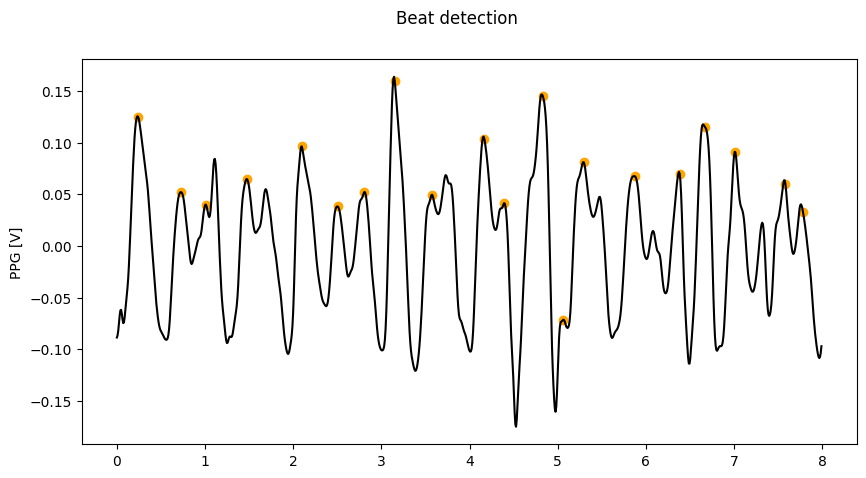

In [4]:
'''
Beat Detection
'''

fs_temp = 125

ppg_beats = {}
for patient in ppg_filt:
    ppg_beats[patient] = pulse_detect(ppg_filt[patient], fs_temp, 5,'upslopes')

patient_num = list(ppg_filt.keys())[0]

fig, (ax1) = plt.subplots(1, 1,
                          sharex = False,
                          sharey = False,
                          figsize = (10,5))

fig.suptitle('Beat detection')
#fs = fs[0][0]
t = np.arange(0, len(ppg_filt[patient_num])/fs_temp,1.0/fs_temp)

beats_y =  [ppg_filt[patient_num][i] for i in ppg_beats[patient_num]]

ax1.plot(t[0:1000], ppg_filt[patient_num], color = 'black')
ax1.scatter(t[0] + ppg_beats[patient_num]/fs_temp,
            beats_y,
            color = 'orange',
            marker = 'o')
ax1.set_ylabel('PPG [V]')

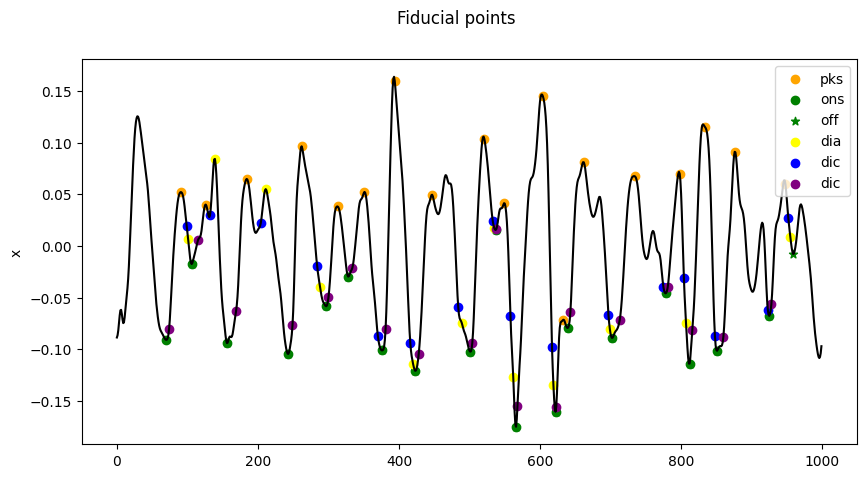

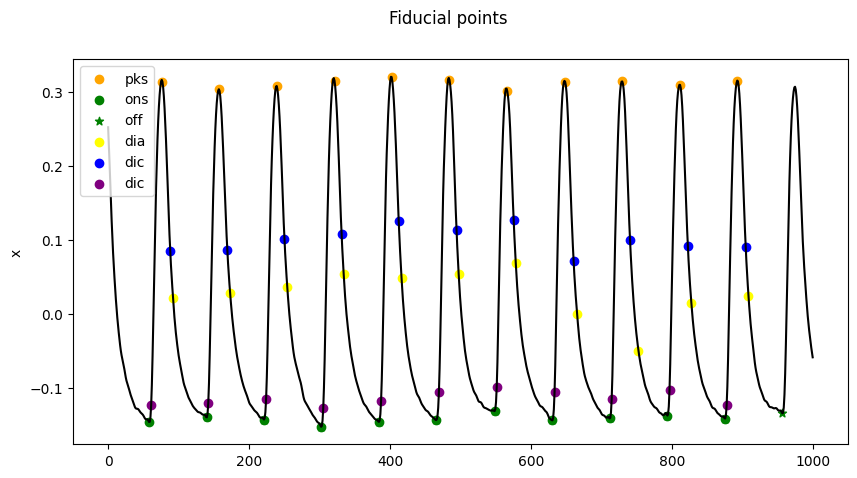

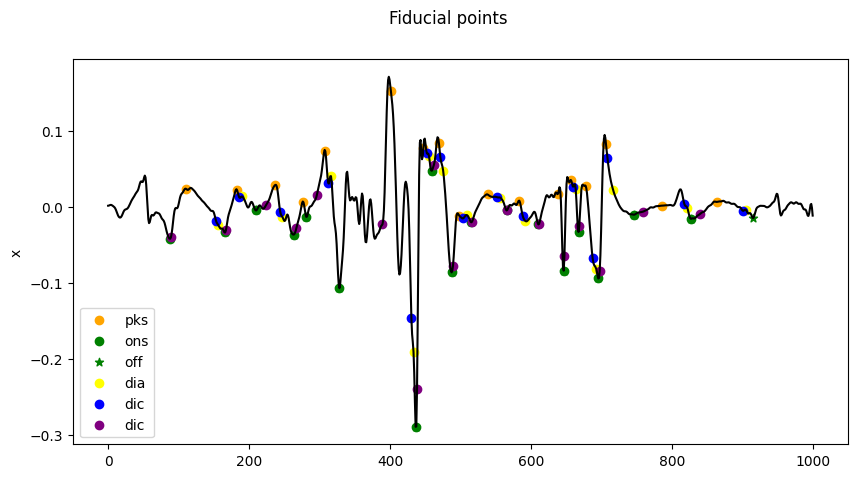

In [5]:
'''
Fiducial Points Detection
'''
fidp = {}

for patient in ppg_filt:
    try:
        fidp[patient] = fiducial_points2(ppg_filt[patient], ppg_beats[patient], fs = 125, vis = True)
    except:
        pass

In [6]:
'''
Calculating Pulse Wave Feature
1. time difference between diastolic and systolic peak
'''

delta_t = {}
fs = 125

for patient in fidp:
    delta_t[patient] = np.zeros(len(fidp[patient]["dia"]))
    for beat_no in range(len(fidp[patient]["dia"])):
        delta_t[patient][beat_no] = (fidp[patient]["dia"][beat_no]-fidp[patient]["pks"][beat_no])/fs
    print("Values of Delta T:")
    print(delta_t)

Values of Delta T:
{'10020306': array([0.08 , 0.104, 0.216, 0.208, 0.856, 1.104, 1.128, 0.92 , 0.784,
       1.2  , 1.624, 2.576])}
Values of Delta T:
{'10020306': array([0.08 , 0.104, 0.216, 0.208, 0.856, 1.104, 1.128, 0.92 , 0.784,
       1.2  , 1.624, 2.576]), '10126957': array([0.12 , 0.128, 0.12 , 0.104, 0.112, 0.104, 0.096, 0.136, 0.184,
       0.128, 0.128])}
Values of Delta T:
{'10020306': array([0.08 , 0.104, 0.216, 0.208, 0.856, 1.104, 1.128, 0.92 , 0.784,
       1.2  , 1.624, 2.576]), '10126957': array([0.12 , 0.128, 0.12 , 0.104, 0.112, 0.104, 0.096, 0.136, 0.184,
       0.128, 0.128]), '10209410': array([0.36 , 0.056, 0.08 , 0.312, 1.   , 0.432, 0.224, 0.32 , 0.464,
       0.424, 0.648, 0.432, 0.48 , 1.152, 1.584])}


In [7]:
'''
Calculating Pulse Wave Feature
2. time difference between systolic peak and onset
'''

ct = {}

for patient in fidp:
    ct[patient] = np.zeros(len(fidp[patient]["pks"]))
    for beat_no in range(len(fidp[patient]["pks"])):
        ct[patient][beat_no] = (fidp[patient]["pks"][beat_no]-fidp[patient]["ons"][beat_no])/fs
    print("Values of CT:")
    print(ct)

Values of CT:
{'10020306': array([0.168, 0.16 , 0.224, 0.152, 0.128, 0.184, 0.144, 0.192, 0.16 ,
       0.096, 0.304, 0.088, 0.184, 0.256, 0.16 , 0.176, 0.208, 0.184])}
Values of CT:
{'10020306': array([0.168, 0.16 , 0.224, 0.152, 0.128, 0.184, 0.144, 0.192, 0.16 ,
       0.096, 0.304, 0.088, 0.184, 0.256, 0.16 , 0.176, 0.208, 0.184]), '10126957': array([0.152, 0.136, 0.144, 0.152, 0.144, 0.152, 0.144, 0.144, 0.144,
       0.144, 0.136])}
Values of CT:
{'10020306': array([0.168, 0.16 , 0.224, 0.152, 0.128, 0.184, 0.144, 0.192, 0.16 ,
       0.096, 0.304, 0.088, 0.184, 0.256, 0.16 , 0.176, 0.208, 0.184]), '10126957': array([0.152, 0.136, 0.144, 0.152, 0.144, 0.152, 0.144, 0.144, 0.144,
       0.144, 0.136]), '10209410': array([0.184, 0.136, 0.216, 0.112, 0.216, 0.584, 0.088, 0.08 , 0.088,
       0.184, 0.136, 0.224, 0.08 , 0.08 , 0.088, 0.32 , 0.304])}


#### 3. Feature Extraction from ABP
##### Next we will work with ABP sinals and Detect Beats Fudicial Points in those signals

##### Next we will use those for Calculating Blood Pressure values from onset and systolic peak
The systolic pressure is the median value of the sysloic peak and the diastolic pressure is the meadian value of the onset

Text(0, 0.5, 'ABP [V]')

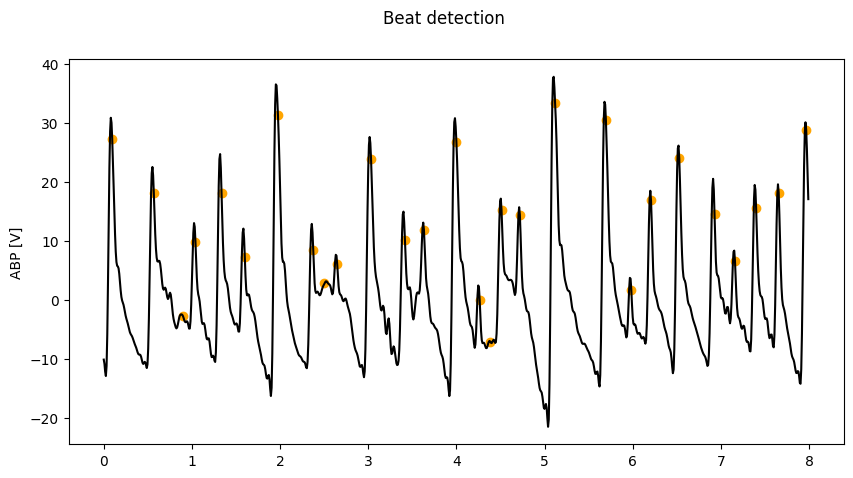

In [8]:
'''
Beat Detection
'''

fs_temp = 125

abp_beats = {}
for patient in abp_filt:
    abp_beats[patient] = pulse_detect(abp_filt[patient], fs_temp, 5,'upslopes')

patient_num = list(abp_filt.keys())[0]

fig, (ax1) = plt.subplots(1, 1,
                          sharex = False,
                          sharey = False,
                          figsize = (10,5))

fig.suptitle('Beat detection')
#fs = fs[0][0]
t = np.arange(0, len(abp_filt[patient_num])/fs_temp,1.0/fs_temp)

beats_y =  [abp_filt[patient_num][i] for i in abp_beats[patient_num]]

ax1.plot(t[0:1000], abp_filt[patient_num], color = 'black')
ax1.scatter(t[0] + abp_beats[patient_num]/fs_temp,
            beats_y,
            color = 'orange',
            marker = 'o')
ax1.set_ylabel('ABP [V]')

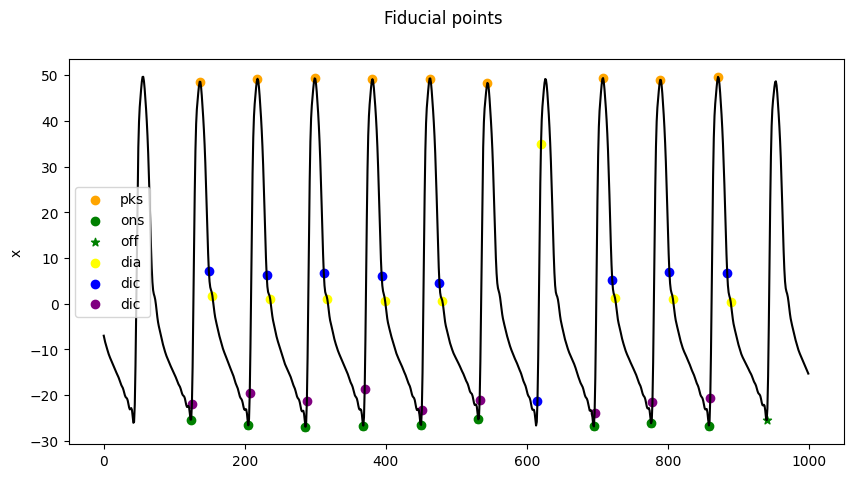

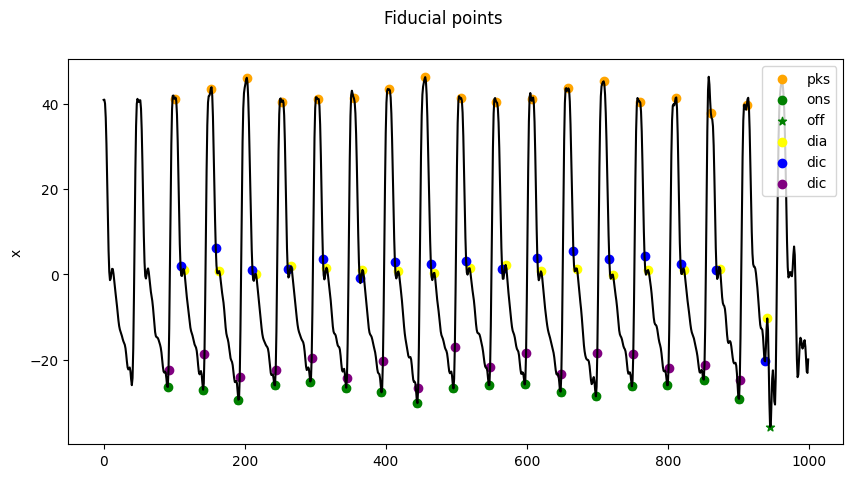

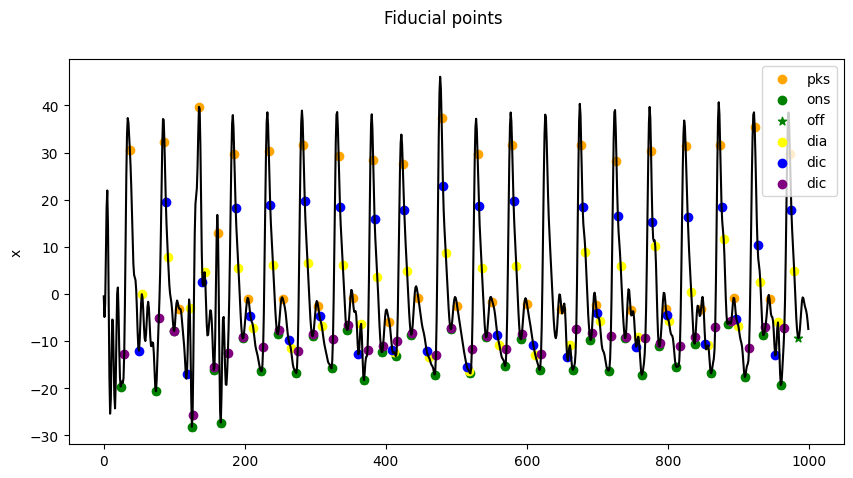

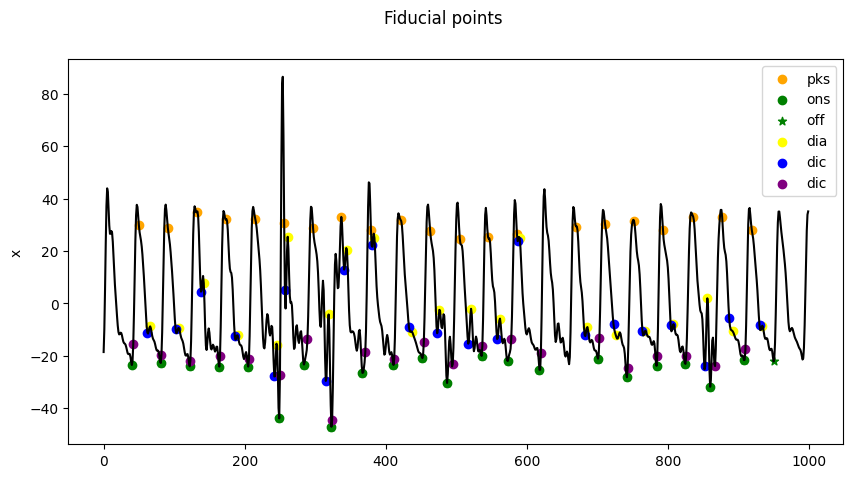

In [9]:
'''
Fiducial Point Detection
'''

fidp = {}

for patient in abp_filt:
    try:
        fidp[patient] = fiducial_points2(abp_filt[patient], abp_beats[patient], fs = 125, vis = True)
    except:
        pass

In [10]:
'''
Calculating Blood Pressure
'''

for patient in fidp:
    #Extract systolic and diastolic BPs:
    sbp = np.median([abp[patient][i]for i in fidp[patient]['pks']])
    dbp = np.median([abp[patient][i]for i in fidp[patient]['ons']])

    #Extract mean blood pressure
    ons = fidp[patient]['ons']
    off = fidp[patient]['off']
    mbps = np.zeros(len(ons))
    for beat_no in range(0,len(ons)):
        mbps[beat_no] = np.mean(abp[patient][ons[beat_no]:off[beat_no]])
    mbp = np.median(mbps)

    #print results
    print('Example patient '+ str(patient)+':')
    print('Systolic blood pressure  (SBP): {:.1f} mmHg'.format(sbp))
    print('Diastolic blood pressure (DBP): {:.1f} mmHg'.format(dbp))
    print('Mean blood pressure      (MBP): {:.1f} mmHg'.format(mbp))
    print('----------------------------------------------------')

Example patient 10126957:
Systolic blood pressure  (SBP): 48.7 mmHg
Diastolic blood pressure (DBP): 53.0 mmHg
Mean blood pressure      (MBP): 69.9 mmHg
----------------------------------------------------
Example patient 10209410:
Systolic blood pressure  (SBP): 80.1 mmHg
Diastolic blood pressure (DBP): 117.4 mmHg
Mean blood pressure      (MBP): 79.2 mmHg
----------------------------------------------------
Example patient 10952189:
Systolic blood pressure  (SBP): 70.1 mmHg
Diastolic blood pressure (DBP): 77.8 mmHg
Mean blood pressure      (MBP): 78.4 mmHg
----------------------------------------------------
Example patient 11109975:
Systolic blood pressure  (SBP): 74.8 mmHg
Diastolic blood pressure (DBP): 91.0 mmHg
Mean blood pressure      (MBP): 76.7 mmHg
----------------------------------------------------


#### 4. Feature Extraction from ECG (II)
##### Lastly we work with ECG signals for Rpeak Extraction and QRS peak detection


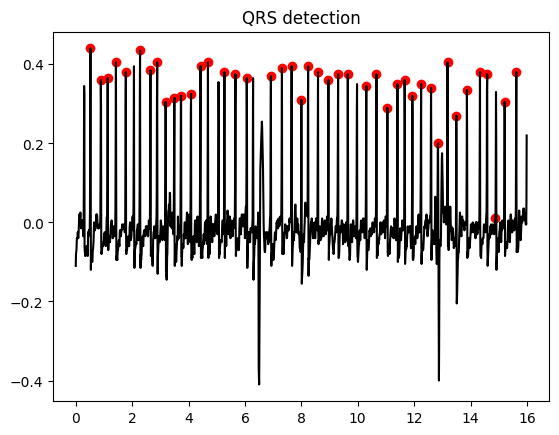

In [11]:
'''
Detect R Peaks
'''

fs_temp = 125

# Detect cardiac cycles
qrs = {}
for patient in ecg:
    try:
        qrs_temp, n_int = qrs_detect(ecg[patient],fs_temp,5)
        qrs[patient]  =qrs_temp
    except:
        continue

pateint_num =  list(qrs.keys())[0]
rpeaks =  [ecg[patient_num][i] for i in qrs[patient_num]]

t = np.arange(0, len(ecg[pateint_num])/fs,1.0/fs)

fig = plt.figure()
plt.title('QRS detection')
plt.plot(t[0:2000], ecg[pateint_num], color = 'black')
plt.scatter(0 + qrs[pateint_num]/fs_temp, rpeaks, color = 'red', marker = 'o')

In [15]:
sampling_rate = 125

all_filtered_signals = {}
all_locs_peaks = {}
all_p_peaks_locs = {}
all_q_peaks_locs = {}
all_features_rpeaks ={}
all_features_waves = {}

for patient in ecg_filt:
    try:
        filtered_ecg, locs_peaks, p_peaks_locs, q_peaks_locs, features_rpeaks, features_waves = find_features(ecg_filt[patient], sampling_rate)
        all_filtered_signals[patient] = filtered_ecg
        all_locs_peaks[patient] = locs_peaks
        all_p_peaks_locs[patient] =p_peaks_locs
        all_q_peaks_locs[patient] = q_peaks_locs
        all_features_rpeaks[patient] = features_rpeaks
        all_features_waves[patient] = features_waves
    except:
        continue

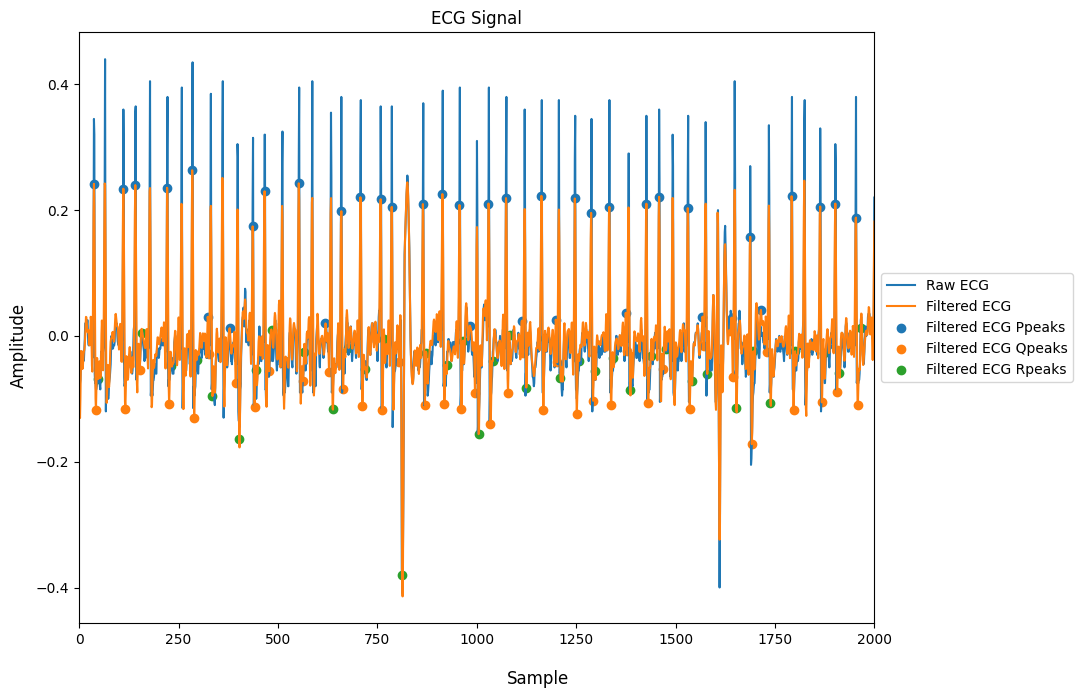

In [16]:
'''
Detect QRS Points
'''
patient_num = list(ecg_filt.keys())[0]

#Generate inputs as dictionaries. The peaks are plotted for raw signal and skipped for filtered signal.
signals={'Raw': ecg[patient_num], 'Filtered': all_filtered_signals[patient_num]}
peaks={'Filtered': {'Ppeaks':all_p_peaks_locs[patient_num], 'Qpeaks': all_q_peaks_locs[patient_num], 'Rpeaks': all_locs_peaks[patient_num]}}

#Plot ECG signal
plot_ecg(signals=signals, peaks=peaks, show_peaks=True, figsize=(11, 7))